<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 12:17:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 16.3 MB/s 
     |████████████████████████████████| 133 kB 66.3 MB/s 
     |████████████████████████████████| 170 kB 65.1 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 138 kB 63.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 957 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 4faudmew
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/4faudmew


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: d517xpyy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
31/31 [==============================] - 14s 25ms/step - loss: 0.7099 - mean_squared_error: 0.7099 - mean_absolute_error: 0.4466 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1337
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0452 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0557
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 8.8404e-04 - mean_squared_error: 8.8404e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0629
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 6.4898e-04 - mean_squared_error: 6.4898e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0627
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0037 - mean_

wandb: Agent Starting Run: 7o02esv2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 19ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1602 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1352
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0260 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1179
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0197 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1066
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0184 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1192
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.

wandb: Agent Starting Run: myjd1eql with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 62ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - mean_absolute_error: 0.2148 - val_loss: 0.3250 - val_mean_squared_error: 0.3250 - val_mean_absolute_error: 0.5266
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - mean_absolute_error: 0.1972 - val_loss: 0.1579 - val_mean_squared_error: 0.1579 - val_mean_absolute_error: 0.3715
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0658 - mean_squared_error: 0.0658 - mean_absolute_error: 0.2247 - val_loss: 0.1004 - val_mean_squared_error: 0.1004 - val_mean_absolute_error: 0.2956
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.2005 - val_loss: 0.0855 - val_mean_squared_error: 0.0855 - val_mean_absolute_error: 0.2712
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mea

wandb: Agent Starting Run: gpj6xckk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.1869 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1472
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0723 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1013
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0207 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1242
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0276 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1125
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011

wandb: Agent Starting Run: wuzr864s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 61ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1085 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0948
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0383 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1214
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0347 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0935
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 9.4743e-04 - mean_squared_error: 9.4743e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0941
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 8.6459e-04 - mean_squared_er

wandb: Agent Starting Run: ui2tsb4v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1130 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1324
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0310 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0920
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0406 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0902
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0258 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1142
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.

wandb: Agent Starting Run: 5v182d8r with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 64ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - mean_absolute_error: 0.1911 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1356
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0440 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1726
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0416 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1449
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0303 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1279
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 

wandb: Agent Starting Run: 3gad4xr6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 60ms/step - loss: 0.4951 - mean_squared_error: 0.4951 - mean_absolute_error: 0.3226 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1061
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 9.5522e-04 - mean_squared_error: 9.5522e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1211
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0392 - val_loss: 0.1535 - val_mean_squared_error: 0.1535 - val_mean_absolute_error: 0.3739
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0617 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1014
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0

wandb: Agent Starting Run: grgg2cq2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 0.0943 - mean_squared_error: 0.0943 - mean_absolute_error: 0.1661 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0910
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0234 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1102
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0386 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0677
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0217 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0755
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 4.9834e-04 - mean_squared_

wandb: Agent Starting Run: e19n3jxn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.1156 - mean_squared_error: 0.1156 - mean_absolute_error: 0.2161 - val_loss: 0.1334 - val_mean_squared_error: 0.1334 - val_mean_absolute_error: 0.3396
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1716 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - val_mean_absolute_error: 0.2374
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1305 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1736
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0849 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1227
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.

wandb: Agent Starting Run: 3urz69k0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 62ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - mean_absolute_error: 0.1499 - val_loss: 0.0989 - val_mean_squared_error: 0.0989 - val_mean_absolute_error: 0.2977
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0754 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1108
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0198 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0972
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0225 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1684
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.00

wandb: Agent Starting Run: 5g55cy5k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.0957 - mean_squared_error: 0.0957 - mean_absolute_error: 0.1860 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1075
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0671 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0906
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0246 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0940
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 9.9876e-04 - mean_squared_error: 9.9876e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0860
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.

wandb: Agent Starting Run: 5hnedhin with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 33ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1370 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.1980
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0576 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1215
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0376 - val_loss: 0.0821 - val_mean_squared_error: 0.0821 - val_mean_absolute_error: 0.2596
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0734 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1133
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_erro

wandb: Agent Starting Run: z46mvjy3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 113ms/step - loss: 0.3376 - mean_squared_error: 0.3376 - mean_absolute_error: 0.3752 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1379
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0852 - val_loss: 0.0722 - val_mean_squared_error: 0.0722 - val_mean_absolute_error: 0.2353
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0715 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1656
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0506 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1370
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025

wandb: Agent Starting Run: tmo1ovgq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 0.1142 - mean_squared_error: 0.1142 - mean_absolute_error: 0.2135 - val_loss: 0.3663 - val_mean_squared_error: 0.3663 - val_mean_absolute_error: 0.5613
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0999 - mean_squared_error: 0.0999 - mean_absolute_error: 0.1925 - val_loss: 0.3108 - val_mean_squared_error: 0.3108 - val_mean_absolute_error: 0.5136
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.1822 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - val_mean_absolute_error: 0.4654
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - mean_absolute_error: 0.1747 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - val_mean_absolute_error: 0.4215
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - m

wandb: Agent Starting Run: 97l8h470 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 63ms/step - loss: 0.9084 - mean_squared_error: 0.9084 - mean_absolute_error: 0.5338 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1061
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0543 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1052
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0404 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1757
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0699 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1129
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - me

wandb: Agent Starting Run: dorxn459 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.1883 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0842
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0424 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0747
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 9.0469e-04 - mean_squared_error: 9.0469e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0715
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 6.1316e-04 - mean_squared_error: 6.1316e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0649
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 4.8778e-04 - me

wandb: Agent Starting Run: 66pv6mr4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 60ms/step - loss: 0.1167 - mean_squared_error: 0.1167 - mean_absolute_error: 0.2090 - val_loss: 0.3785 - val_mean_squared_error: 0.3785 - val_mean_absolute_error: 0.5713
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.1027 - mean_squared_error: 0.1027 - mean_absolute_error: 0.2019 - val_loss: 0.2842 - val_mean_squared_error: 0.2842 - val_mean_absolute_error: 0.4914
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - mean_absolute_error: 0.1915 - val_loss: 0.2138 - val_mean_squared_error: 0.2138 - val_mean_absolute_error: 0.4277
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - mean_absolute_error: 0.1889 - val_loss: 0.1708 - val_mean_squared_error: 0.1708 - val_mean_absolute_error: 0.3842
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0554 - mean_squared_error: 0.

wandb: Agent Starting Run: 9c2wxv21 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 23ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.0954 - val_loss: 0.2268 - val_mean_squared_error: 0.2268 - val_mean_absolute_error: 0.4617
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0667 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0852
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0278 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1255
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0381 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1370
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.

wandb: Agent Starting Run: 8uklz77d with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 67ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1226 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1180
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0261 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1022
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0362 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1027
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0249 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1005
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028

wandb: Agent Starting Run: 5l3hahvy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 33ms/step - loss: 49.6675 - mean_squared_error: 49.6675 - mean_absolute_error: 3.5420 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0921
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0489 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0790
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1604 - mean_squared_error: 0.1604 - mean_absolute_error: 0.2510 - val_loss: 0.1503 - val_mean_squared_error: 0.1503 - val_mean_absolute_error: 0.3675
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1329 - mean_squared_error: 0.1329 - mean_absolute_error: 0.2666 - val_loss: 0.1770 - val_mean_squared_error: 0.1770 - val_mean_absolute_error: 0.4034
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0515 - mean_squared_er

wandb: Agent Starting Run: uf0nbzg4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 66ms/step - loss: 62.6785 - mean_squared_error: 62.6785 - mean_absolute_error: 4.1885 - val_loss: 0.0890 - val_mean_squared_error: 0.0890 - val_mean_absolute_error: 0.2401
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1274 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2109
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1079 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - val_mean_absolute_error: 0.1827
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0895 - val_loss: 0.0813 - val_mean_squared_error: 0.0813 - val_mean_absolute_error: 0.1820
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0657 - mean_squared_error: 1.0657 - m

wandb: Agent Starting Run: biwgl3xq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 63ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - mean_absolute_error: 0.1793 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2189
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0828 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1442
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0422 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0858
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0252 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0870
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.0011

wandb: Agent Starting Run: msr0e9dr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - mean_absolute_error: 0.1486 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1150
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0272 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1044
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0218 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1054
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 8.8119e-04 - mean_squared_error: 8.8119e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0987
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 8.0269e-04 - mean_squar

wandb: Agent Starting Run: rwwkvaet with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 66ms/step - loss: 0.1472 - mean_squared_error: 0.1472 - mean_absolute_error: 0.2412 - val_loss: 0.3321 - val_mean_squared_error: 0.3321 - val_mean_absolute_error: 0.5354
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - mean_absolute_error: 0.1692 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.2210
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1072 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1542
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0819 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1219
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - m

wandb: Agent Starting Run: pvxn7gvg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 20ms/step - loss: 0.1219 - mean_squared_error: 0.1219 - mean_absolute_error: 0.2119 - val_loss: 0.2959 - val_mean_squared_error: 0.2959 - val_mean_absolute_error: 0.5020
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - mean_absolute_error: 0.1893 - val_loss: 0.1715 - val_mean_squared_error: 0.1715 - val_mean_absolute_error: 0.3855
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.2009 - val_loss: 0.1291 - val_mean_squared_error: 0.1291 - val_mean_absolute_error: 0.3351
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1830 - val_loss: 0.0975 - val_mean_squared_error: 0.0975 - val_mean_absolute_error: 0.2903
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0324 - mean_squared_erro

wandb: Agent Starting Run: 3vszk0lj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 65ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - mean_absolute_error: 0.2509 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1207
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0919 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0921
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0717 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1450
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1026
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_squared_error: 0.0011

wandb: Agent Starting Run: dh2zfrgt with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 28.7883 - mean_squared_error: 28.7883 - mean_absolute_error: 2.8845 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1365
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0311 - val_loss: 0.0812 - val_mean_squared_error: 0.0812 - val_mean_absolute_error: 0.2374
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.7035 - mean_squared_error: 0.7035 - mean_absolute_error: 0.5460 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1878
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0847 - mean_squared_error: 0.0847 - mean_absolute_error: 0.2082 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0788
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0148 - mean_squared_error: 

wandb: Agent Starting Run: i1smg6hp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 63.2406 - mean_squared_error: 63.2406 - mean_absolute_error: 3.5791 - val_loss: 0.1088 - val_mean_squared_error: 0.1088 - val_mean_absolute_error: 0.2515
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.0950 - val_loss: 8.7490 - val_mean_squared_error: 8.7490 - val_mean_absolute_error: 2.8681
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0870 - mean_squared_error: 1.0870 - mean_absolute_error: 0.6998 - val_loss: 5.3788 - val_mean_squared_error: 5.3788 - val_mean_absolute_error: 2.2661
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8662 - mean_squared_error: 0.8662 - mean_absolute_error: 0.6070 - val_loss: 0.1100 - val_mean_squared_error: 0.1100 - val_mean_absolute_error: 0.2420
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2249 - mean_squared_er

wandb: Agent Starting Run: rxkkdxaz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 31ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1553 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1734
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0420 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1105
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0298 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1119
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0208 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1096
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 9.0378e-04 - mean_squared_error

wandb: Agent Starting Run: bw1g7wo5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1400 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0892
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0277 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0844
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0209 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0819
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 7.3211e-04 - mean_squared_error: 7.3211e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0811
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 7.3117e-04 - mean_

wandb: Agent Starting Run: ffv4octs with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1413 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1127
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0439 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1021
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0250 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1051
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0226 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1147
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - 

wandb: Agent Starting Run: p8i6yyqj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - mean_absolute_error: 0.1820 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1326
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0455 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1087
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 8.8814e-04 - mean_squared_error: 8.8814e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1054
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 6.6907e-04 - mean_squared_error: 6.6907e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1041
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 8.2973e-04 - me

wandb: Agent Starting Run: sddwtbsx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 38ms/step - loss: 0.1125 - mean_squared_error: 0.1125 - mean_absolute_error: 0.1449 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1108
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0468 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0803
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0242 - val_loss: 0.0587 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.2196
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0349 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1515
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_err

wandb: Agent Starting Run: 3kpxgjiv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.1838 - mean_squared_error: 0.1838 - mean_absolute_error: 0.2796 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1010
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0413 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1162
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0590 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_mean_absolute_error: 0.2360
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0805 - val_loss: 0.0796 - val_mean_squared_error: 0.0796 - val_mean_absolute_error: 0.2596
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0164 - mean_squared_error: 0.

wandb: Agent Starting Run: q3v1paza with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 31.0334 - mean_squared_error: 31.0334 - mean_absolute_error: 3.2089 - val_loss: 0.1684 - val_mean_squared_error: 0.1684 - val_mean_absolute_error: 0.2749
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0521 - val_loss: 0.1588 - val_mean_squared_error: 0.1588 - val_mean_absolute_error: 0.2638
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - mean_absolute_error: 0.2467 - val_loss: 0.0773 - val_mean_squared_error: 0.0773 - val_mean_absolute_error: 0.1891
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0358 - val_loss: 0.1107 - val_mean_squared_error: 0.1107 - val_mean_absolute_error: 0.3078
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1086 - mean_squared_error: 

wandb: Agent Starting Run: omdvrci8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 23ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1118 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1025
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0240 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0989
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0286 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0965
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0695 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0835
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_err

wandb: Agent Starting Run: udxibyfn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.1063 - mean_squared_error: 0.1063 - mean_absolute_error: 0.1990 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1204
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0629 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0957
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 8.3257e-04 - mean_squared_error: 8.3257e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0898
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 6.9864e-04 - mean_squared_error: 6.9864e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0937
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 7.8684e-0

wandb: Agent Starting Run: r1rleubm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - mean_absolute_error: 0.1602 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1673
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0603 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0977
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 9.7717e-04 - mean_squared_error: 9.7717e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0712
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0260 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0759
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 6.9628e-04 - m

wandb: Agent Starting Run: 7q38su83 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 0.1566 - mean_squared_error: 0.1566 - mean_absolute_error: 0.2728 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1636
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0824 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1629
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0732 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1199
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0275 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1137
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - 

wandb: Agent Starting Run: gzt4jdlo with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0540 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1151
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 8.0654e-04 - mean_squared_error: 8.0654e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0932
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 6.1378e-04 - mean_squared_error: 6.1378e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0852
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 5.3638e-04 - mean_squared_error: 5.3638e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0804
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 4.

wandb: Agent Starting Run: qzpiwyba with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1391 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1056
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0323 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.2412
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0667 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1359
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0371 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.2408
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0152 - mean_squared_error:

wandb: Agent Starting Run: aqg9ub85 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 69ms/step - loss: 0.0650 - mean_squared_error: 0.0650 - mean_absolute_error: 0.1625 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1230
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0264 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - val_mean_absolute_error: 0.2609
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0808 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0950
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0238 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1187
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0

wandb: Agent Starting Run: cka1k002 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 0.1724 - mean_squared_error: 0.1724 - mean_absolute_error: 0.2273 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1337
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0238 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1382
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0309 - val_loss: 0.1700 - val_mean_squared_error: 0.1700 - val_mean_absolute_error: 0.3873
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0705 - val_loss: 0.0865 - val_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.2612
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - 

wandb: Agent Starting Run: fl1g8vbv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 63ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1347 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1003
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0460 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1036
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0431 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1017
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 8.6107e-04 - mean_squared_error: 8.6107e-04 - mean_absolute_error: 0.0214 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0833
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 6.6289e-04 - mean_squared_

wandb: Agent Starting Run: nweg8a2i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 71ms/step - loss: 0.8818 - mean_squared_error: 0.8818 - mean_absolute_error: 0.4454 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1262
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0283 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.2348
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0888 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1245
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0316 - val_loss: 0.1173 - val_mean_squared_error: 0.1173 - val_mean_absolute_error: 0.3196
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0238 - mean_squared_error: 0.0238 -

wandb: Agent Starting Run: l1nvok13 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 33.7366 - mean_squared_error: 33.7366 - mean_absolute_error: 3.2786 - val_loss: 0.1641 - val_mean_squared_error: 0.1641 - val_mean_absolute_error: 0.3497
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9012 - mean_squared_error: 0.9012 - mean_absolute_error: 0.7133 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1339
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3251 - mean_squared_error: 0.3251 - mean_absolute_error: 0.2802 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1159
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1139 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1640
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0236 - mean_squared_er

wandb: Agent Starting Run: 5xq74wjk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 20ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1099 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1421
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0285 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0948
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 9.1910e-04 - mean_squared_error: 9.1910e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0860
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 7.9197e-04 - mean_squared_error: 7.9197e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0918
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_s

wandb: Agent Starting Run: blhqhdst with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1262 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1074
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0266 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0880
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0204 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0812
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 8.3617e-04 - mean_squared_error: 8.3617e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0706
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 8.2183e-04 - mean_

wandb: Agent Starting Run: 1qv53mlk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 68ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - mean_absolute_error: 0.2129 - val_loss: 0.2286 - val_mean_squared_error: 0.2286 - val_mean_absolute_error: 0.4416
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.1904 - val_loss: 0.0796 - val_mean_squared_error: 0.0796 - val_mean_absolute_error: 0.2622
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1738 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.2187
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1120 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1280
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - me

wandb: Agent Starting Run: 0hrthe4o with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error:

wandb: Agent Starting Run: tmqts7mu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.1752 - mean_squared_error: 0.1752 - mean_absolute_error: 0.2626 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1230
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0242 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1265
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0323 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - val_mean_absolute_error: 0.2679
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0979 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1220
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - 

wandb: Agent Starting Run: ffmhi1s0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.0988 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1070
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0297 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0971
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0348 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0950
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0289 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1566
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.

wandb: Agent Starting Run: uobuj1cz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 39ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1313 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1106
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0233 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0953
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 9.9621e-04 - mean_squared_error: 9.9621e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0929
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 9.5148e-04 - mean_squared_error: 9.5148e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0935
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0010 - me

wandb: Agent Starting Run: ohp2lfm7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 2s 19ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - mean_absolute_error: 0.2188 - val_loss: 0.2363 - val_mean_squared_error: 0.2363 - val_mean_absolute_error: 0.4489
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - mean_absolute_error: 0.1974 - val_loss: 0.1353 - val_mean_squared_error: 0.1353 - val_mean_absolute_error: 0.3431
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1894 - val_loss: 0.1110 - val_mean_squared_error: 0.1110 - val_mean_absolute_error: 0.3102
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1720 - val_loss: 0.0811 - val_mean_squared_error: 0.0811 - val_mean_absolute_error: 0.2638
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0251 - mean_squared_erro

wandb: Agent Starting Run: top07ly2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 3s 25ms/step - loss: 2.1065 - mean_squared_error: 2.1065 - mean_absolute_error: 0.6317 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1595
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0291 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0507
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0257 - val_loss: 0.9115 - val_mean_squared_error: 0.9115 - val_mean_absolute_error: 0.9483
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 1.3331 - mean_squared_error: 1.3331 - mean_absolute_error: 0.8101 - val_loss: 1.0746 - val_mean_squared_error: 1.0746 - val_mean_absolute_error: 0.9905
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0938 - mean_squared_

wandb: Agent Starting Run: hpck232i with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 18.2754 - mean_squared_error: 18.2754 - mean_absolute_error: 2.0082 - val_loss: 0.2776 - val_mean_squared_error: 0.2776 - val_mean_absolute_error: 0.4836
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2934 - mean_squared_error: 0.2934 - mean_absolute_error: 0.3314 - val_loss: 0.0590 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.1646
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.6709 - mean_squared_error: 0.6709 - mean_absolute_error: 0.5517 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0689
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.3587 - mean_squared_error: 0.3587 - mean_absolute_error: 0.1845 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.2134
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_er

wandb: Agent Starting Run: aztaf6yh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 0.6163 - mean_squared_error: 0.6163 - mean_absolute_error: 0.4143 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1067
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0468 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0809
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0261 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0879
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 8.9891e-04 - mean_squared_error: 8.9891e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0615
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squ

wandb: Agent Starting Run: oyaegcru with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1583 - val_loss: 0.1116 - val_mean_squared_error: 0.1116 - val_mean_absolute_error: 0.3113
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0750 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1055
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0503 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1289
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0443 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1030
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 -

wandb: Agent Starting Run: cpp9ia59 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 76ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1418 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1118
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0362 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1461
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0735 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0982
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0248 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0885
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 7.2267e-04 - mean_squared_error:

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1269, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/retry.py", line 102, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 130, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/u

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 1s 5ms/step - loss: 0.2430
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0289
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 8.2548e-04
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 8.3546e-04
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 6.3265e-04
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 6.2918e-04
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 5.6846e-04
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 4.3528e-04
Epoch 13/100


In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

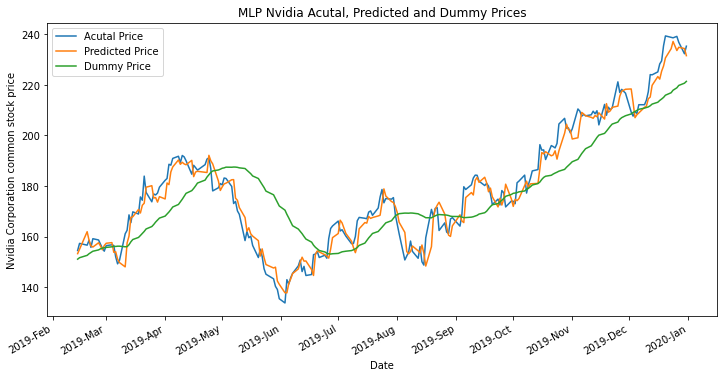

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

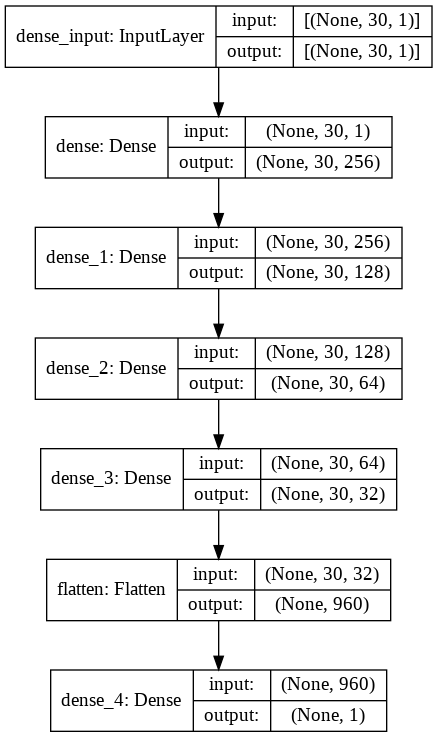

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0025718669984406183
RMSE:  0.050713578048098895
MAE:  0.04022438388480344
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Nvidia/assets
